<a href="https://colab.research.google.com/github/ntolayd/Projects/blob/main/Recommendation_Engines/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import warnings
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error
warnings.filterwarnings('ignore')

In [3]:
#data loading
!unzip "/content/gdrive/My Drive/ml-1m.zip"
masked = pd.read_csv('/content/gdrive/MyDrive/masked_melted.csv')
test_set = pd.read_csv('/content/gdrive/MyDrive/test_set.csv')
with open(r'/content/gdrive/MyDrive/masked_idx.pkl', "rb") as input_file:
  masked_idx = pickle.load(input_file)
movies = pd.read_csv("ml-1m/movies.dat", sep='::', engine='python', header=None)
movies.columns = ['movie_id', 'movie_name', 'genre']
ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', engine='python', header=None)
ratings.columns=['user_id', 'movie_id', 'rating','timestamp']

Archive:  /content/gdrive/My Drive/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [4]:
masked = masked[~(masked['value'] == 0)]

Base Model

In [5]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Concatenate, Dropout, merge
from keras.layers.merge import Multiply
from keras.layers.merge import Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l1, l2

In [6]:
unique_movie_numb = masked['movie_id'].max()
unique_user_numb = masked['user_id'].max()

In [7]:
masked['value'] = masked['value'] / 5

In [8]:
embedding_size= 5

#Movie input
input_movies = Input(shape=[1])
embed_movies = Embedding(unique_movie_numb + 1, embedding_size,name = 'movie_embedding')(input_movies)
movies_out = Flatten()(embed_movies)

#user network
input_users = Input(shape=[1])
embed_users = Embedding(unique_user_numb + 1, embedding_size,name = 'user_embedding')(input_users)
users_out = Flatten()(embed_users)

y = Dot(1, normalize=False)([users_out, movies_out])

model = Model(inputs=[input_users, input_movies], outputs=y)

model.compile(loss='mse',
              optimizer=Adam(lr=0.001),
              metrics=['mae']
             )

In [9]:
history = model.fit([masked["user_id"], masked["movie_id"]]
                    , masked["value"] 
                    , batch_size=128, epochs=10
                    , validation_split=0.1
                    , shuffle=True)


Epoch 1/10
5627/5627 [==============================] - 32s 3ms/step - loss: 0.3500 - mae: 0.5052 - val_loss: 0.5279 - val_mae: 0.6912
Epoch 2/10
5627/5627 [==============================] - 16s 3ms/step - loss: 0.0363 - mae: 0.1502 - val_loss: 0.5277 - val_mae: 0.6907
Epoch 3/10
5627/5627 [==============================] - 16s 3ms/step - loss: 0.0343 - mae: 0.1462 - val_loss: 0.5277 - val_mae: 0.6907
Epoch 4/10
5627/5627 [==============================] - 16s 3ms/step - loss: 0.0336 - mae: 0.1449 - val_loss: 0.5277 - val_mae: 0.6907
Epoch 5/10
5627/5627 [==============================] - 16s 3ms/step - loss: 0.0328 - mae: 0.1428 - val_loss: 0.5278 - val_mae: 0.6907
Epoch 6/10
5627/5627 [==============================] - 16s 3ms/step - loss: 0.0319 - mae: 0.1408 - val_loss: 0.5278 - val_mae: 0.6907
Epoch 7/10
5627/5627 [==============================] - 16s 3ms/step - loss: 0.0310 - mae: 0.1386 - val_loss: 0.5279 - val_mae: 0.6908
Epoch 8/10
5627/5627 [==============================] -

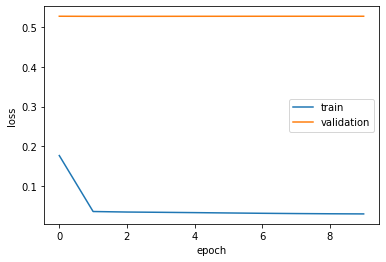

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

In [11]:
predictions = model.predict([test_set["user_id"], test_set["movie_id"]]) * 5
print(mean_absolute_error(test_set['rating'], predictions))
print(math.sqrt(mean_squared_error(test_set['rating'], predictions)))

0.9759076315153195
1.4291143559495048


In [16]:
movie_ids = masked['movie_id'].unique()


#recommender
def make_recommendation(user_id, k):
  user = np.array([user_id for i in range(len(movie_ids))])
  predictions = model.predict([user, movie_ids])
  predictions = [i[0] for i in predictions]
  df = pd.DataFrame({'user_id':user, 'movie_id':movie_ids, 'Recommendation_Score':predictions}).sort_values(by='Recommendation_Score', ascending=False).head(k)
  return df

In [17]:
def apk(actual, predicted, k=10):

    if len(actual) == 0:
      return 0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)


    return score / min(len(actual), k)

In [18]:
def apk_user(user_id,k):
  user_avg = masked[masked['user_id']== user_id]['value'].mean()*5
  user_test = test_set[test_set['user_id'] == user_id][['movie_id','rating']]
  user_test = user_test[user_test['rating'] >= user_avg]['movie_id'].values
  rec = make_recommendation(user_id,k)
  rec = rec['movie_id']
  return apk(user_test, rec, k)

In [15]:
mean_apk = np.mean([apk_user(i,30) for i in masked['user_id'].unique()])
print(mean_apk)

0.008302908305776475


Deeper model

In [8]:
embedding_size= 10

#Movie input
input_movies = Input(shape=[1])
embed_movies = Embedding(unique_movie_numb + 1,embedding_size,name = 'movie_embedding')(input_movies)
movies_out = Flatten()(embed_movies)

#user input
input_users = Input(shape=[1])
embed_users = Embedding(unique_user_numb + 1,embedding_size,name = 'user_embedding')(input_users)
users_out = Flatten()(embed_users)


input_vecs = Concatenate()([users_out, movies_out])


x = Dense(256, activation='relu')(input_vecs)
x = Dropout(0.3)(x)


y = Dense(1,activation='relu')(x)

model = Model(inputs=[input_users, input_movies], outputs=y)

model.compile(loss='mse',
              optimizer=Adam(lr=0.001),
              metrics=['mae']
             )

In [9]:
history = model.fit([masked["user_id"], masked["movie_id"]]
                    , masked["value"] 
                    , batch_size=128, epochs=10
                    , validation_split=0.1
                    , shuffle=True)


Epoch 1/10
5627/5627 [==============================] - 35s 4ms/step - loss: 0.0484 - mae: 0.1685 - val_loss: 0.0458 - val_mae: 0.1740
Epoch 2/10
5627/5627 [==============================] - 20s 4ms/step - loss: 0.0326 - mae: 0.1429 - val_loss: 0.0456 - val_mae: 0.1722
Epoch 3/10
5627/5627 [==============================] - 20s 3ms/step - loss: 0.0312 - mae: 0.1393 - val_loss: 0.0455 - val_mae: 0.1723
Epoch 4/10
5627/5627 [==============================] - 19s 3ms/step - loss: 0.0303 - mae: 0.1370 - val_loss: 0.0458 - val_mae: 0.1736
Epoch 5/10
5627/5627 [==============================] - 20s 4ms/step - loss: 0.0299 - mae: 0.1361 - val_loss: 0.0455 - val_mae: 0.1724
Epoch 6/10
5627/5627 [==============================] - 20s 3ms/step - loss: 0.0295 - mae: 0.1352 - val_loss: 0.0455 - val_mae: 0.1720
Epoch 7/10
5627/5627 [==============================] - 19s 3ms/step - loss: 0.0292 - mae: 0.1344 - val_loss: 0.0459 - val_mae: 0.1741
Epoch 8/10
5627/5627 [==============================] -

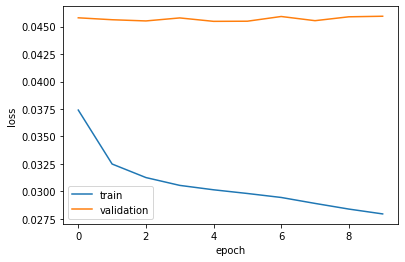

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

In [11]:
predictions = model.predict([test_set["user_id"], test_set["movie_id"]]) * 5
print(mean_absolute_error(test_set['rating'], predictions))
print(math.sqrt(mean_squared_error(test_set['rating'], predictions)))

0.6975244589045628
0.8900835459419596


In [19]:
mean_apk = np.mean([apk_user(i,30) for i in masked['user_id'].unique()])
print(mean_apk)

0.016510220754933327


NeuMF Model

In [35]:
input_movies = Input(shape=[1])
input_users = Input(shape=[1])
latent_dim = 10

mf_user_embedding = Embedding(input_dim=unique_user_numb + 1, output_dim=latent_dim,
                    name='mf_user_embedding', input_length=1)

mf_item_embedding = Embedding(input_dim=unique_movie_numb + 1, output_dim=latent_dim,
                    name='mf_item_embedding', input_length=1)

mlp_user_embedding = Embedding(input_dim=unique_user_numb + 1, output_dim=128,
                      name='mlp_user_embedding',
                      input_length=1)

mlp_item_embedding = Embedding(input_dim=unique_movie_numb + 1, output_dim=128,
                      name='mlp_item_embedding',
                      input_length=1)

# MF latent vector
mf_user_latent = Flatten()(mf_user_embedding(input_users))
mf_item_latent = Flatten()(mf_item_embedding(input_movies))
mf_cat_latent = Multiply()([mf_user_latent, mf_item_latent])

# MLP latent vector
mlp_user_latent = Flatten()(mlp_user_embedding(input_users))
mlp_item_latent = Flatten()(mlp_item_embedding(input_movies))
mlp_cat_latent = Concatenate()([mlp_user_latent, mlp_item_latent])

mlp_vector = mlp_cat_latent


layer = Dense(256, activation='relu')
mlp_vector = layer(mlp_vector)

predict_layer = Concatenate()([mf_cat_latent, mlp_vector])
result = Dense(1, activation='relu')

model = Model(inputs=[input_users,input_movies], outputs=result(predict_layer))

model.compile(loss='mse',
              optimizer=Adam(lr=0.001),
              metrics=['mae']
             )

In [36]:
def get_model(num_users, num_items, mf_dim=10, layers=[256]):

    num_layer = len(layers) #Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users+1, output_dim = mf_dim, name = 'mf_embedding_user',
                                  input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items+1, output_dim = mf_dim, name = 'mf_embedding_item',
                                  input_length=1)   

    MLP_Embedding_User = Embedding(input_dim = num_users+1, output_dim = int(layers[0]/2), name = "mlp_embedding_user",
                                   input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items+1, output_dim = int(layers[0]/2), name = 'mlp_embedding_item',
                                   input_length=1)   
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent])
    
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], activation='relu', name="layer%d" %idx)
        mlp_vector = layer(mlp_vector)

    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation='relu', name = "prediction")(predict_vector)
    
    model = Model(inputs=[user_input, item_input], 
                  outputs=prediction)
    
    return model

In [37]:
model = get_model(unique_user_numb, unique_movie_numb)

In [38]:
model.compile(loss='mse',
              optimizer=Adam(lr=0.001),
              metrics=['mae']
             )

In [39]:
history = model.fit([masked["user_id"], masked["movie_id"]]
                    , masked["value"] 
                    , batch_size=128, epochs=10
                    , validation_split=0.1
                    , shuffle=True)

Epoch 1/10
5627/5627 [==============================] - 71s 13ms/step - loss: 0.0643 - mae: 0.1880 - val_loss: 0.0643 - val_mae: 0.2138
Epoch 2/10
5627/5627 [==============================] - 71s 13ms/step - loss: 0.0305 - mae: 0.1378 - val_loss: 0.0519 - val_mae: 0.1887
Epoch 3/10
5627/5627 [==============================] - 73s 13ms/step - loss: 0.0275 - mae: 0.1300 - val_loss: 0.0478 - val_mae: 0.1788
Epoch 4/10
5627/5627 [==============================] - 72s 13ms/step - loss: 0.0262 - mae: 0.1269 - val_loss: 0.0512 - val_mae: 0.1862
Epoch 5/10
5627/5627 [==============================] - 72s 13ms/step - loss: 0.0255 - mae: 0.1251 - val_loss: 0.0475 - val_mae: 0.1783
Epoch 6/10
5627/5627 [==============================] - 71s 13ms/step - loss: 0.0250 - mae: 0.1237 - val_loss: 0.0472 - val_mae: 0.1781
Epoch 7/10
5627/5627 [==============================] - 71s 13ms/step - loss: 0.0247 - mae: 0.1227 - val_loss: 0.0475 - val_mae: 0.1790
Epoch 8/10
5627/5627 [==========================

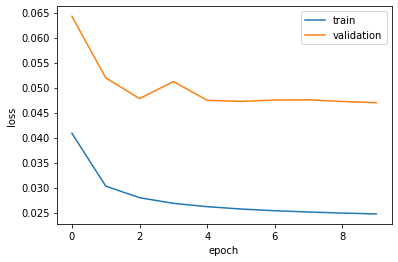

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

In [41]:
predictions = model.predict([test_set["user_id"], test_set["movie_id"]]) * 5
print(mean_absolute_error(test_set['rating'], predictions))
print(math.sqrt(mean_squared_error(test_set['rating'], predictions)))

0.7023501948955585
0.901515448332707


In [42]:
mean_apk_enhanced = np.mean([apk_user(i,30) for i in masked['user_id'].unique()])
print(mean_apk_enhanced)

0.009126687881948575
